In [66]:
import random
import string
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import math

from matplotlib.patches import Rectangle  

class WorldNode:
    
    def __init__(self, name):
        self.id = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(8))
        self.people = {}
        self.name = name
        
    def run_infection(self):
        ''' Give everyone in the room a chance to get sick. Each sick person has
            a level of contagiousness which represents the probability of them
            infecting a person that comes near them. The contagiousness should be
            some function of the time that the person has been sick (maybe 1/n or such).
            
            We model the probability of a person being infected as the union of interactions
            with sick people in the room as follows: '''
        threat = 0
        for k in self.people:
            if self.people[k].infected:
                threat += self.people[k].get_contagiousness()
        # Use logistic function to clamp the probability between 0 and 1
        threat = 1.0 / (1 + math.exp(-threat)) - 0.5   
        for k in self.people:
            if not self.people[k].infected:
                if random.random() < threat:
                    self.people[k].infect()
                    
    def add_person(self, p):
        self.people[p.name] = p
        
    def remove_person(self, p):
        del self.people[p.name]
                                                
class Person:
    
    ''' The actual person class would probably include other things like a probability distribution of where they go
        from each node. '''
    
    def __init__(self, schedule):
        # Number of people infected is determined by this. To get a proportion of the population to
        # be infected, use self.infected = random.random() < x, where x is e.g. 0.05 for 5% of the population
#         self.infected = random.choice([True, False])
        self.infected = random.random() < .05
        # How infectious the diease is
        self.contagiousness = max(random.random(), 0.1) if self.infected else 0
        self.name = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(8))
        self.fixed_nodes = {}
        self.other_nodes = {}
        self.schedule = schedule
        self.current_node = None
        
    def get_scheduled_node(self, t):
        ''' If there is a scheduled place to be at this time, return it, otherwise return None.'''
        for (start, end, name) in self.schedule:
            if t >= start and t < end:
                return self.fixed_nodes[name]
        
    def add_node(self, node, fixed_name=None):
        if fixed_name == "Home":
            self.move_to_node(node)
            
        if fixed_name != None:
            self.fixed_nodes[fixed_name] = node
        else:
            self.other_nodes[node.name] = node
            
    def randomize_nodes(self):
        probs = [random.random() for _ in range(len(self.other_nodes))]
        total = sum(probs)
        while total > 1.0:
            probs = [p * 0.95 for p in probs]
            total = sum(probs)
        x = 1.0 - total
        probs[len(probs)-1] += x
        self.other_node_probs = probs
        
    def infect(self):
        self.infected = True
        
    def set_rate(self):
        self.contagiousness = rate
        
    def get_contagiousness(self):
        return self.contagiousness
        
    def cure(self):
        self.infected = False
        
    def choose_next_node(self):
        ''' Pick a random node that is not one of the fixed ones (school etc) '''
        cumulative_prob = 0
        r = random.random()
        for name, prob in zip(list(self.other_nodes.keys()), self.other_node_probs):
            cumulative_prob += prob
            if r < cumulative_prob:
                return self.other_nodes[name]
        raise Exception("Could not choose next node")
        
    def move_to_node(self, node):
        if self.current_node != None:
            self.current_node.remove_person(self)
        self.current_node = node
        self.current_node.add_person(self)

def create_person(homes, workplaces, schools, other, schedule, num_nodes):
    p = Person(schedule)
    p.add_node(random.choice(homes), fixed_name="Home")
    p.add_node(random.choice(workplaces), fixed_name="Work")
    p.add_node(random.choice(schools), fixed_name="School")
    for node in random.sample(other, num_nodes - 3):
        p.add_node(node)
    p.randomize_nodes()
    return p

def make_nodes(names):
    return [WorldNode(name) for name in names]



def visualize_world(all_nodes, fig=plt):
    # Build a grid that looks like
    # [1][2][3]
    # [4][5][6]
    # [7][8][9]
    n = math.ceil(math.sqrt(len(all_nodes)))
    cell_side = 0.8 # Cell side length
    # n by n grid
    # Assign nodes to squares
    nodes = {}
    for i, node in enumerate(all_nodes):
        nodes[i] = node
    def index_to_xy(i):
        return(i % n, int(i/n))
    
    xs = []
    ys = []
    
    for k in nodes:
        node = nodes[k]
        x, y = index_to_xy(k)
        for person in node.people.values():
            px = x + random.random()*cell_side
            py = y + random.random()*cell_side
            color = 'red' if person.infected else 'blue'
            plt.scatter([px], [py], color=color)
            xs.append(px)
            ys.append(py)
        if "Home" in node.name:
            node_color = 'purple'
        elif "Work" in node.name:
            node_color = 'yellow'
        elif "School" in node.name:
            node_color = 'green'

        currentAxis = fig.gca()
        currentAxis.add_patch(Rectangle((x, y), 1*cell_side, 1*cell_side, facecolor="none", edgecolor=node_color))
        #currentAxis.set_title(node.name)
    plt.axes().set_aspect('equal', 'datalim')
    plt.axis('off')
    plt.ylim((-5,10))
    #plt.show()

from IPython.display import display, clear_output
# Pass in the number of iterations to do and the number of people
def visualize_simulation(iters, num_people):
    
    def make_nodes(names):
        return [WorldNode(name) for name in names]
    
    times = []
    infected_nums = []
    
    homes = make_nodes(list(set([("Home %d") % i for i in range(10)])))
    workplaces = make_nodes(list(set([("Work %d") % i for i in range(10)])))
    schools = make_nodes(list(set([("School %d") % i for i in range(10)])))
    
    other_types = ["Hobby", "Restaurant"]
    other = make_nodes(list(set([("%s %d") % (random.choice(other_types), i) for i in range(10)])))
    
    schedules = [[(0, 8, "Home"), (8, 15, "School"), (17, 21, "Work"), (23, 24, "Home")], \
                 [(0, 8, "Home"), (8, 15, "School"), (23, 24, "Home")], [(0,6, "Home"), (7, 18, "Work"), (19, 24, "Home")],
                [(0,6, "Home"), (7, 15, "School"), (17, 24, "Home")], [(0,7, "Work"), (8,16, "Home"), (17, 24, "Work")],
                [(0,8, "Home"), (9, 13, "Work"), (14, 20, "School"), (21, 24, "Home")],
                [(0,3, "Work"), (4,18, "Home"), (18, 24, "Work")], [(0,14, "Home"), (15, 24, "Work")],
                [(0,7, "Home"), (8,18, "Work"), (17, 24, "Home")], [(0,7, "Home"), (8,18, "Work"), (17, 20, "School"), (21,24,"Home")]]

    people = [create_person(homes, workplaces, schools, other, random.choice(schedules), random.randint(6, 10)) for _ in range(num_people)]
    all_nodes = homes + workplaces + schools + other
    
    fig, ax = plt.subplots(figsize =(8,8))
    
    for i in range(iters):
        time = i % 24
        times.append(time)
        day = 1 + i // 24
        infected_nums.append(sum([int(p.infected) for p in people]))
        ''' Move people if they should move '''
        for p in people:
            n = p.get_scheduled_node(time)
            if n == None:
                n = p.choose_next_node()
            if n.name != p.current_node.name:
                p.move_to_node(n)
        for n in all_nodes:
            n.run_infection()
        plt.title("Day " + str(day)+ " " + str(time) + ":00" + "\n" + str(infected_nums[i]) + "/" + str(num_people) + " infected")

        clear_output(wait=True)
        display(fig)
        fig.clear()
        visualize_world(all_nodes, fig=fig)

    
# Pass in the number of iterations to do and the number of people
def run_simulation(iters, num_people):
    
    def make_nodes(names):
        return [WorldNode(name) for name in names]
    
    times = []
    infected_nums = []
    
    homes = make_nodes(list(set([("Home %d") % i for i in range(10)])))
    workplaces = make_nodes(list(set([("Work %d") % i for i in range(10)])))
    schools = make_nodes(list(set([("School %d") % i for i in range(10)])))
    
    other_types = ["Hobby", "Restaurant"]
    other = make_nodes(list(set([("%s %d") % (random.choice(other_types), i) for i in range(10)])))
    
    schedules = [[(0, 8, "Home"), (8, 15, "School"), (17, 21, "Work"), (23, 24, "Home")], \
                 [(0, 8, "Home"), (8, 15, "School"), (23, 24, "Home")], [(0,6, "Home"), (7, 16, "Work"), (17, 24, "Home")]]

    people = [create_person(homes, workplaces, schools, other, random.choice(schedules), random.randint(6, 10)) for _ in range(num_people)]
    all_nodes = homes + workplaces + schools + other
        
    for i in range(iters):
        time = i % 24
        times.append(time)
        infected_nums.append(sum([int(p.infected) for p in people]))
        ''' Move people if they should move '''
        for p in people:
            n = p.get_scheduled_node(time)
            if n == None:
                n = p.choose_next_node()
            if n.name != p.current_node.name:
                p.move_to_node(n)
        for n in all_nodes:
            n.run_infection()
            
    
    return (people, all_nodes, times, infected_nums)

                
    



    

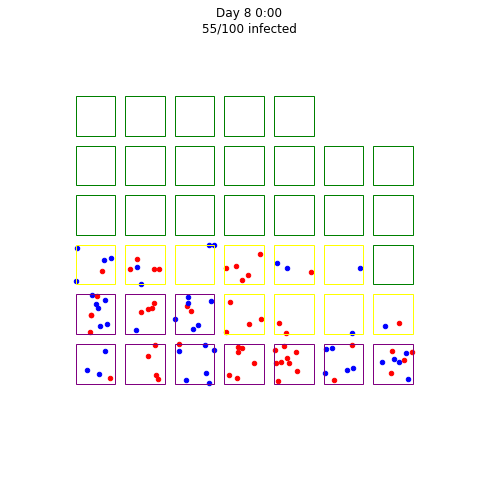

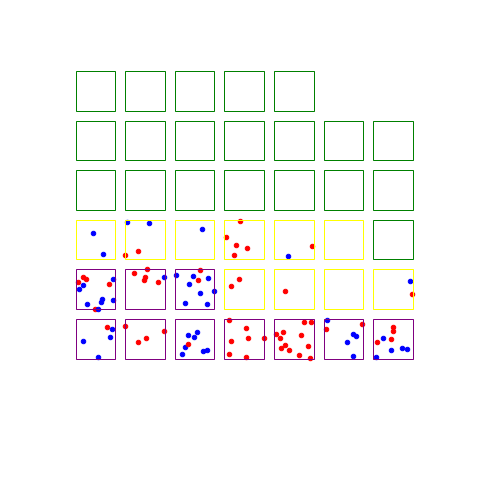

In [68]:
visualize_simulation(169, 100)
